# GNN

In [1]:
pip install torch_geometric torch

  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
  Using cached torch-2.6.0-cp311-cp311-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached filelock-3.17.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_

In [2]:
pip install ast

  Using cached AST-0.0.2.tar.gz (19 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [8 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-70ple18t/ast_4ef6d65edb5c446db7bce3ffe80882bd/setup.py", line 6, in <module>
          README = codecs.open(os.path.join(here, 'AST/README'), encoding='utf8').read()
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "<frozen codecs>", line 918, in open
      FileNotFoundError: [Errno 2] No such file or directory: '/tmp/pip-install-70ple18t/ast_4ef6d65edb5c446db7bce3ffe80882bd/AST/README'
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered erro

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import ast


In [4]:
# Load data
train_data = pd.read_csv('../02_data/train_test/train_data.csv')
test_data = pd.read_csv('../02_data/train_test/test_data.csv')

In [5]:
edge_df = pd.read_csv('../02_data/train_test/train_edge_list.csv') 
edge_list = edge_df.to_numpy()

In [6]:
domains = train_data['domain'].unique()
len(domains)

4753

In [7]:
domains = test_data['domain'].unique()
len(domains)

1189

In [8]:
edge_df["chat_id"].nunique()

21147

In [9]:
edge_list.shape

(1519640, 2)

In [10]:
edge_np = np.load("../02_data/train_test/validated_edges.npy", allow_pickle=True)
edge_nodes = set(edge_np.flatten())  # Unique nodes appearing in edges
train_nodes = set(train_data["domain_index"].values)

print(f"Total Nodes in Edge List: {len(edge_nodes)}")
print(f"Total Nodes in Train Data: {len(train_nodes)}")

valid_nodes = edge_nodes & train_nodes  # Only keep nodes present in both
edge_np = np.array([edge for edge in edge_np if edge[0] in valid_nodes and edge[1] in valid_nodes])
#train_data = train_data[train_data["domain_index"].isin(valid_nodes)].copy()

Total Nodes in Edge List: 4775
Total Nodes in Train Data: 4753


In [11]:
edge_np.shape

(154254, 2)

In [12]:
node_ids = sorted(train_data["domain_index"].values)  # Sorted list of valid node IDs
node_id_to_index = {old_id: new_idx for new_idx, old_id in enumerate(node_ids)}  # Map old ID -> new index

In [13]:
mapped_edges = np.array([
    [node_id_to_index[edge[0]], node_id_to_index[edge[1]]] 
    for edge in edge_np if edge[0] in node_id_to_index and edge[1] in node_id_to_index
])

train_data["node_index"] = train_data["domain_index"].map(node_id_to_index)

In [14]:
mapped_edges.shape

(154254, 2)

In [15]:
train_data.info() # columns: domain, domain_index, url_index, article, article_embedding, virality, avalanches, messages, chats, year, pc1, label

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4753 entries, 0 to 4752
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   domain             4753 non-null   object 
 1   domain_index       4753 non-null   int64  
 2   url_index          4753 non-null   int64  
 3   article            4753 non-null   object 
 4   article_embedding  4753 non-null   object 
 5   virality           4753 non-null   float64
 6   avalanches         4753 non-null   float64
 7   messages           4753 non-null   float64
 8   chats              4753 non-null   float64
 9   year               4753 non-null   float64
 10  pc1                4753 non-null   float64
 11  label              4753 non-null   int64  
 12  node_index         4753 non-null   int64  
dtypes: float64(6), int64(4), object(3)
memory usage: 482.9+ KB


In [16]:
# Split train_data into train and validation sets
train_domains, val_domains = train_test_split(train_data['node_index'], test_size=0.2, random_state=42)


In [17]:
len(train_domains)

3802

In [18]:
# Convert to sets for fast lookup
train_domains_set = set(train_domains)
val_domains_set = set(val_domains)

# Filter edge list
#train_edges = edge_list[(edge_list['domain_index'].isin(train_domains_set))]
#val_edges = edge_list[(edge_list['domain_index'].isin(val_domains_set))]


In [19]:
# print(len(train_edges))
# print(len(val_edges))
# print(len(edge_list))

In [20]:
import numpy as np
import re

def preprocess_embedding(emb):
    """
    Preprocess and clean embedding values. Handles cases where:
    - The embedding is a string (requires cleaning and parsing).
    - The embedding is already a numpy array (no further processing needed).

    Args:
        emb: Embedding data (string or numpy array).

    Returns:
        np.array: Cleaned numpy array of embeddings.

    Raises:
        ValueError: If the data cannot be cleaned or converted.
    """
    # If it's already a numpy array, return as is
    if isinstance(emb, np.ndarray):
        return emb

    # If it's a list or other iterable, convert it to a numpy array
    if isinstance(emb, (list, tuple)):
        return np.array(emb, dtype=np.float32)

    # If it's a string, clean and parse
    if isinstance(emb, str):
        try:
            # Fix missing commas using regex
            emb = re.sub(r'(?<=\d)\s+(?=\d|\-)', ',', emb)
            # Ensure it is wrapped in brackets
            if not emb.startswith("["):
                emb = "[" + emb
            if not emb.endswith("]"):
                emb = emb + "]"
            # Evaluate the cleaned string and convert to numpy array
            parsed_emb = eval(emb)  # Using eval since we sanitize the string
            return np.array(parsed_emb, dtype=np.float32)
        except Exception as e:
            raise ValueError(f"Failed to process embedding: {emb}. Error: {e}")

    # If none of the above, raise an error
    raise ValueError(f"Unsupported embedding format: {type(emb)}")


In [31]:
train_data['article_embedding'] = train_data['article_embedding'].apply(preprocess_embedding)
#node_features['article_embedding'] = node_features['article_embedding'].apply(preprocess_embedding)

In [35]:
import torch
import numpy as np

def preprocess_train_data(train_data):
    """
    Combines multiple features into a single tensor for graph node features.
    
    Args:
        train_data (DataFrame): DataFrame containing the features:
            - 'article_embedding': preprocessed numpy arrays
            - 'virality': numeric
            - 'chats': numeric
            - 'messages': numeric
            - 'year': numeric
    
    Returns:
        torch.Tensor: Combined tensor of node features.
    """
    # Ensure 'article_embedding' is preprocessed
    embeddings = np.vstack(train_data['article_embedding'].values)

    # Extract other features and convert them to numpy arrays
    other_features = train_data[['virality', 'year', 'avalanches', 'messages']].to_numpy(dtype=np.float32)

    # Combine article embeddings with the other features
    combined_features = np.hstack((embeddings, other_features)) #embeddings, 

    # Convert to torch tensor
    return torch.tensor(combined_features, dtype=torch.float32) #combined_features


In [36]:
def prepare_graph_data(test_data, train_data, edges):
    # train validation split
    train_domains, val_domains = train_test_split(train_data['node_index'], test_size=0.2, random_state=42)
    train_domains_set = set(train_domains)
    val_domains_set = set(val_domains)

    # Combine node features into a single tensor
    x = preprocess_train_data(train_data)
    
    # Convert to PyTorch tensor
    edge_index = torch.tensor(edges.T, dtype=torch.long) #.to_numpy()
    
    # Prepare labels (if available)
    y = torch.tensor(train_data['label'].values, dtype=torch.long) if 'label' in train_data else None
    
    train_mask = torch.tensor(train_data['node_index'].isin(train_domains_set).values, dtype=torch.bool)
    val_mask = torch.tensor(train_data['node_index'].isin(val_domains_set).values, dtype=torch.bool)
    test_mask = torch.tensor(test_data['domain_index'].values, dtype=torch.bool)
    
    return Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask) 

# Prepare the graph data
data = prepare_graph_data(test_data, train_data, mapped_edges)


In [37]:
print(f"Number of domains: {data.x.shape[0]}") # 4753
print(f"in chats: {data.x.shape[1]}") # 388

Number of domains: 4753
in chats: 388


In [25]:
print(f"Max node index in edge_index: {data.edge_index.max()}") # 64976
print(f"Min node index in edge_index: {data.edge_index.min()}") # 0
print(f"Number of nodes in data.x: {data.x.shape[0]}")

Max node index in edge_index: 4752
Min node index in edge_index: 0
Number of nodes in data.x: 4753


In [26]:
class GCNBasic(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNBasic, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        #self.dropout = nn.Dropout(p=0.1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        #x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return torch.log_softmax(x, dim=1)

In [27]:
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=0.01)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        #x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        #x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return torch.log_softmax(x, dim=1)


In [28]:
# Model configuration
input_dim = data.x.shape[1]
hidden_dim = 64
output_dim = len(train_data['label'].unique())
model = GCNBasic(input_dim, hidden_dim, output_dim)

# Training configuration
optimizer = optim.Adam(model.parameters(), lr=0.0001) # , weight_decay=5e-4 l2 regularization
criterion = nn.CrossEntropyLoss()

In [29]:
model

GCNBasic(
  (conv1): GCNConv(388, 64)
  (conv2): GCNConv(64, 2)
)

In [33]:
# Training loop
train_losses = []
val_losses = []

def train(model, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Validation
def validate(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        loss = criterion(out[data.val_mask], data.y[data.val_mask])
    return loss.item()

# Train the model
num_epochs = 100
for epoch in range(1, num_epochs + 1):
    train_loss = train(model, data)
    val_loss = validate(model, data)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")


Epoch 10, Loss: 0.8446, Validation Loss: 0.7168
Epoch 20, Loss: 0.8574, Validation Loss: 0.8605
Epoch 30, Loss: 0.6715, Validation Loss: 0.6898
Epoch 40, Loss: 0.6308, Validation Loss: 0.6737
Epoch 50, Loss: 0.6094, Validation Loss: 0.6627
Epoch 60, Loss: 0.6002, Validation Loss: 0.6504
Epoch 70, Loss: 0.5897, Validation Loss: 0.6387
Epoch 80, Loss: 0.5786, Validation Loss: 0.6265
Epoch 90, Loss: 0.5689, Validation Loss: 0.6163
Epoch 100, Loss: 0.5601, Validation Loss: 0.6067


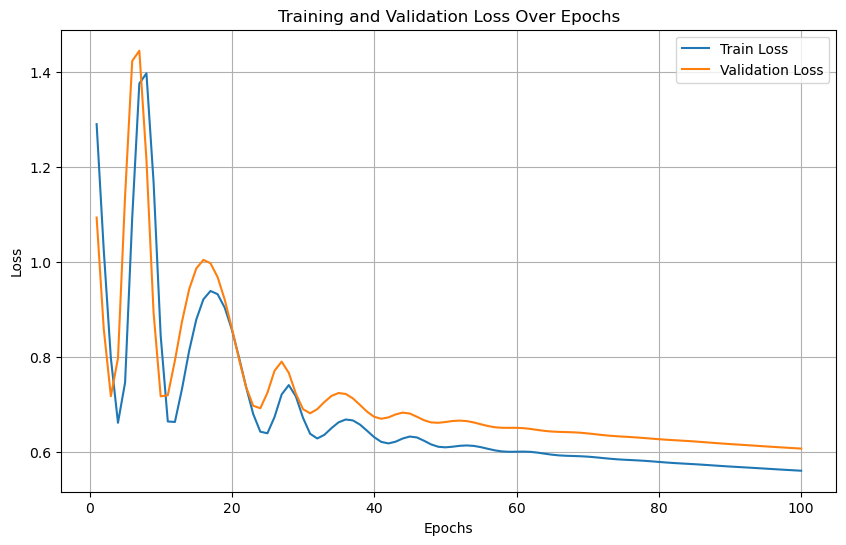

In [34]:
# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.savefig("../03_plots/train_val_gcn60.png")  # Save as PNG
plt.show()

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.54      0.10      0.16      1208
     Class 1       0.76      0.97      0.85      3545

    accuracy                           0.75      4753
   macro avg       0.65      0.53      0.51      4753
weighted avg       0.70      0.75      0.68      4753



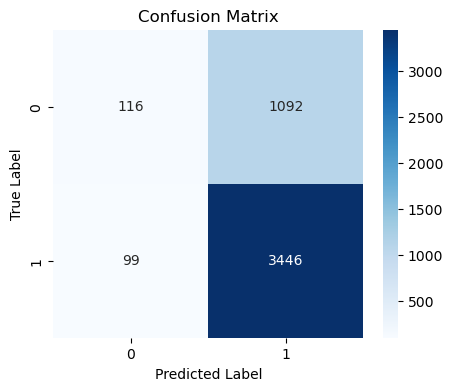

In [35]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import torch

def plot_confusion_matrix(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        preds = out.argmax(dim=1).cpu().numpy()
        labels = data.y.cpu().numpy()

    # Compute confusion matrix
    cm = confusion_matrix(labels, preds)

    # Compute classification report
    class_report = classification_report(labels, preds, target_names=[f"Class {i}" for i in range(len(set(labels)))])
    
    # Print classification report
    print("Classification Report:\n", class_report)

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.savefig('../03_plots/con_matrix_GCN.png') #, dpi=300, bbox_inches="tight"
    plt.show()

plot_confusion_matrix(model, data)
